<center> <h1>Prediction For Individual Country</h1> </center>

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [2]:
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

### Importing The Covid Dataset

In [3]:
url = 'https://raw.githubusercontent.com/datasets/covid-19/main/data/time-series-19-covid-combined.csv'
df = pd.read_csv(url)
df.head()

,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,0,0.00,0
1,2020-01-23,Afghanistan,NaN,0,0.00,0
2,2020-01-24,Afghanistan,NaN,0,0.00,0
3,2020-01-25,Afghanistan,NaN,0,0.00,0
4,2020-01-26,Afghanistan,NaN,0,0.00,0


### Filtering One Country & Specifying Future Days

In [4]:
country = df[df['Country/Region'] == "Zambia"]
days = 60

### Adding New Feature

In [5]:
country['CurrentCase'] = country['Confirmed'] - country['Recovered'] - country['Deaths']

In [6]:
country.tail()

,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths,CurrentCase
103627,2021-02-01,Zambia,NaN,55042,49394.00,780,4868.00
103628,2021-02-02,Zambia,NaN,56233,49696.00,794,5743.00
103629,2021-02-03,Zambia,NaN,57489,50479.00,804,6206.00
103630,2021-02-04,Zambia,NaN,59003,51305.00,812,6886.00
103631,2021-02-05,Zambia,NaN,60427,52045.00,828,7554.00


### Grouping Dates & Making Univariate Dataset

In [7]:
confirmed = country.groupby('Date').sum()['Confirmed'].reset_index()
recovered = country.groupby('Date').sum()['Recovered'].reset_index()
deaths = country.groupby('Date').sum()['Deaths'].reset_index()
current_case = country.groupby('Date').sum()['CurrentCase'].reset_index()

In [8]:
confirmed.tail(10)

,Date,Confirmed
371,2021-01-27,48911
372,2021-01-28,50319
373,2021-01-29,51624
374,2021-01-30,53352
375,2021-01-31,54217
376,2021-02-01,55042
377,2021-02-02,56233
378,2021-02-03,57489
379,2021-02-04,59003
380,2021-02-05,60427


In [9]:
recovered

,Date,Recovered
0,2020-01-22,0.00
1,2020-01-23,0.00
2,2020-01-24,0.00
3,2020-01-25,0.00
4,2020-01-26,0.00
...,...,...
376,2021-02-01,49394.00
377,2021-02-02,49696.00
378,2021-02-03,50479.00
379,2021-02-04,51305.00


In [10]:
deaths

,Date,Deaths
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0
...,...,...
376,2021-02-01,780
377,2021-02-02,794
378,2021-02-03,804
379,2021-02-04,812


In [11]:
current_case

,Date,CurrentCase
0,2020-01-22,0.00
1,2020-01-23,0.00
2,2020-01-24,0.00
3,2020-01-25,0.00
4,2020-01-26,0.00
...,...,...
376,2021-02-01,4868.00
377,2021-02-02,5743.00
378,2021-02-03,6206.00
379,2021-02-04,6886.00


### Removing Unnecessary Columns

In [12]:
del country['Province/State']
country

,Date,Country/Region,Confirmed,Recovered,Deaths,CurrentCase
103251,2020-01-22,Zambia,0,0.00,0,0.00
103252,2020-01-23,Zambia,0,0.00,0,0.00
103253,2020-01-24,Zambia,0,0.00,0,0.00
103254,2020-01-25,Zambia,0,0.00,0,0.00
103255,2020-01-26,Zambia,0,0.00,0,0.00
...,...,...,...,...,...,...
103627,2021-02-01,Zambia,55042,49394.00,780,4868.00
103628,2021-02-02,Zambia,56233,49696.00,794,5743.00
103629,2021-02-03,Zambia,57489,50479.00,804,6206.00
103630,2021-02-04,Zambia,59003,51305.00,812,6886.00


In [13]:
confirmed.tail()

,Date,Confirmed
376,2021-02-01,55042
377,2021-02-02,56233
378,2021-02-03,57489
379,2021-02-04,59003
380,2021-02-05,60427


### Converting Date Format to Python Date Format

In [14]:
country["Date"] = pd.to_datetime(country["Date"])
confirmed["Date"] = pd.to_datetime(confirmed["Date"])
deaths['Date'] = pd.to_datetime(deaths['Date'])

### Plotting/ Visualization

In [15]:
confirmed.iplot(kind='bar', x='Date', y='Confirmed')

### Rename Function

In [16]:
def rename_func(dataframe):
    columns = dataframe.columns
    dataframe = dataframe.rename(columns= {columns[0]: 'ds', columns[1]: 'y'})
    return dataframe

In [17]:
confirmed = rename_func(confirmed)
recovered = rename_func(recovered)
deaths = rename_func(deaths)
current_case = rename_func(current_case)


In [18]:
confirmed.shape

(381, 2)

### Initializing Prophet Instance

In [19]:
from fbprophet import Prophet
model = Prophet(daily_seasonality=False, yearly_seasonality=False, holidays=None,  interval_width=0.95, growth='linear')

In [20]:
model.add_seasonality(name="Monthly", period=30.42, fourier_order=25)

### Training Model With Last 6 Month Data

In [21]:
model.fit(confirmed.iloc[int(confirmed.shape[0]/2):])
print("Model Trained Successfully. ")

Model Trained Successfully. 


In [22]:
future_dates = model.make_future_dataframe(days)
print("Future Dataframe Generated Successfully. ")

Future Dataframe Generated Successfully. 


In [23]:
future_dates.tail()

,ds
246,2021-04-02
247,2021-04-03
248,2021-04-04
249,2021-04-05
250,2021-04-06


### Making Prediction (Confirmed Cases)

In [24]:
prediction = model.predict(future_dates)

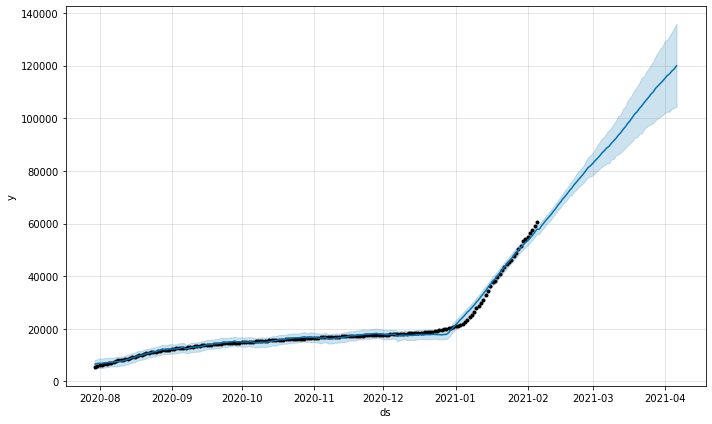

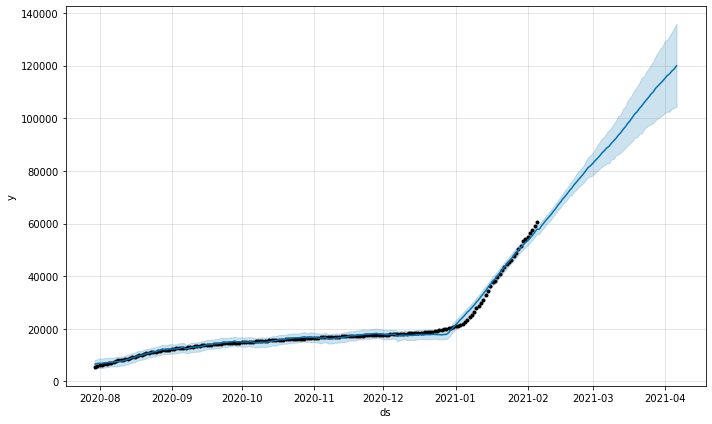

In [25]:
model.plot(prediction)

In [26]:
prediction.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Monthly,Monthly_lower,Monthly_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
246,2021-04-02,115890.26,102473.37,129771.52,102221.38,129498.08,183.69,183.69,183.69,301.88,301.88,301.88,118.19,118.19,118.19,0.00,0.00,0.00,116192.13
247,2021-04-03,116929.28,102446.62,131251.18,102798.23,130966.65,-23.89,-23.89,-23.89,-67.77,-67.77,-67.77,-43.88,-43.88,-43.88,0.00,0.00,0.00,116861.51
248,2021-04-04,117968.30,103655.86,132709.93,103375.34,132540.33,-52.91,-52.91,-52.91,-27.03,-27.03,-27.03,25.88,25.88,25.88,0.00,0.00,0.00,117941.27
249,2021-04-05,119007.32,103901.16,134254.98,103953.07,133982.67,-274.17,-274.17,-274.17,-296.87,-296.87,-296.87,-22.69,-22.69,-22.69,0.00,0.00,0.00,118710.46
250,2021-04-06,120046.35,104416.96,135940.82,104571.28,135415.72,-57.92,-57.92,-57.92,-113.63,-113.63,-113.63,-55.70,-55.70,-55.70,0.00,0.00,0.00,119932.72


In [27]:
approximation = prediction[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]

In [28]:
confirmed.tail()

,ds,y
376,2021-02-01,55042
377,2021-02-02,56233
378,2021-02-03,57489
379,2021-02-04,59003
380,2021-02-05,60427


### Making Prediction (Deaths)

In [29]:
from fbprophet import Prophet
new_model = Prophet(daily_seasonality=False, yearly_seasonality=False)

In [30]:
new_model.add_seasonality(name="Monthly", period=30.42, fourier_order=25)

In [31]:
new_model.fit(deaths.iloc[int(deaths.shape[0]/2):])
print("Model Trained Successfully. ")

Model Trained Successfully. 


In [32]:
new_future_dates = new_model.make_future_dataframe(days)
print("Future Dataframe Generated Successfully. ")

Future Dataframe Generated Successfully. 


In [33]:
deaths_prediction = new_model.predict(new_future_dates)

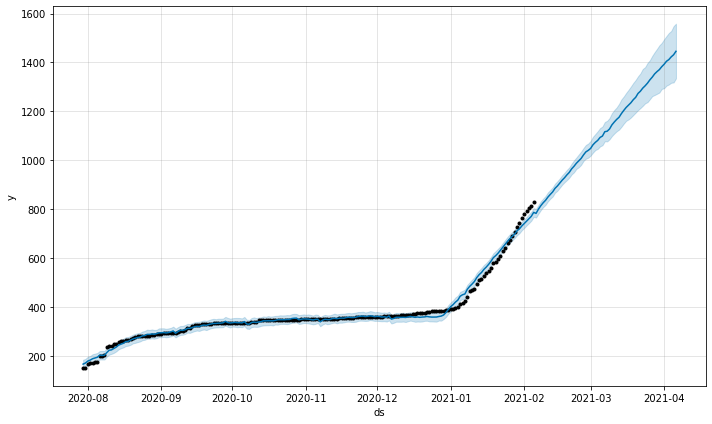

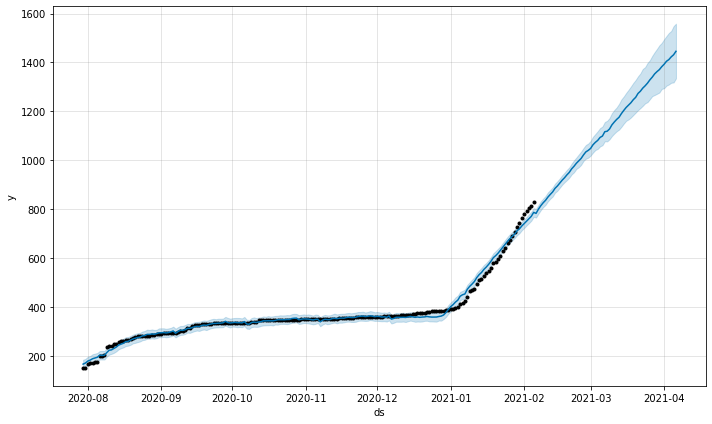

In [34]:
new_model.plot(deaths_prediction)

In [35]:
deaths_approximation = deaths_prediction[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]

In [36]:
deaths_approximation.tail()

,ds,yhat_lower,yhat,yhat_upper
246,2021-04-02,1305.12,1404.74,1507.84
247,2021-04-03,1309.96,1411.72,1520.54
248,2021-04-04,1316.81,1422.83,1528.77
249,2021-04-05,1318.24,1431.39,1548.49
250,2021-04-06,1334.58,1445.57,1558.76


In [37]:
print("Total Confirmed Cases after {a} Days : {b}      range = {c} ~ {d}".format(a=days, b = int(approximation.iloc[approximation.shape[0] - 1]['yhat']), c = int(approximation.iloc[approximation.shape[0] - 1]['yhat_lower']), d = int(approximation.iloc[approximation.shape[0] - 1]['yhat_upper'])))
print("Total Deaths Cases after {a} Days : {b}      range = {c} ~ {d}".format(a=days, b = int(deaths_approximation.iloc[approximation.shape[0] - 1]['yhat']), c = int(deaths_approximation.iloc[approximation.shape[0] - 1]['yhat_lower']), d = int(deaths_approximation.iloc[approximation.shape[0] - 1]['yhat_upper'])))

Total Confirmed Cases after 60 Days : 119932      range = 104416 ~ 135940
Total Deaths Cases after 60 Days : 1445      range = 1334 ~ 1558
